In [1]:
from forge import *
from puzzle.puzzlepedia import prod_config

prod_config.init()

In [8]:
import cv2
import glob
import itertools
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from os import path
from sklearn.neighbors import NearestNeighbors
from typing import Iterable, Tuple

from data import data
from util import perf
from util.geometry import np2d
from data.image import analysis, coloring, component, component_database, grid, utils

import importlib
importlib.reload(analysis)
importlib.reload(grid)
importlib.reload(image)
importlib.reload(np2d)
importlib.reload(utils)
importlib.reload(coloring)


_FILE_PATTERN = '*.png'
_MAX = 255
_WHITE = [_MAX, _MAX, _MAX]
_THRESHOLD = 5
_SIZES = []
_FOCUS = {
}
pos = 16
for backwards in range(-1, -11, -1):
  for _ in range(0, 8):
    _SIZES.append(pos)
    pos += 1
  _SIZES.append(16 + backwards)

  
def image_path(name: str, subdir: str = 'original') -> str:
  return path.join(data.project_path('data/grid'), subdir, name)


def get_img(name, subdir: str = 'original'):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  return cv2.imread(image_path(name, subdir=subdir), flags=cv2.IMREAD_UNCHANGED)


def get_grid(name, subdir: str = 'original'):
  return grid.Grid(get_img(name, subdir=subdir))


def show(label, img=None):
  if img is None:
    img = label
  else:
    print(label)
  display(Image.fromarray(np.array(img, dtype=np.uint8)))


def show_components(g):
  db = component_database.ComponentDatabase()

  shown = set()
  for c in g.components:
    identified = db.identify(c)
    symbol = identified.labels.get('symbol')
    if symbol is None:
      pass
    elif symbol in shown:
      continue
    shown.add(symbol)
    show(c.image)


def imgs(subdir: str = 'original') -> Iterable[np.ndarray]:
  for filename in sorted(glob.glob(image_path(_FILE_PATTERN, subdir))):
    yield (
      path.basename(filename),
      cv2.imread(filename, flags=cv2.IMREAD_UNCHANGED))


def grids(subdir: str = 'original') -> Iterable[Tuple[str, grid.Grid]]:
  for name, img in imgs(subdir):
    if _FOCUS and name not in _FOCUS:
      continue
    yield name, grid.Grid(img)


def images() -> Iterable[image.Image]:
  for name, img in imgs():
    if _FOCUS and name not in _FOCUS:
      continue
    yield name, image.Image(img)
    
_PADDING = 8


def study(*segments, padding=_PADDING):
  """Studies line segments."""
  segments = [np.array(s) for s in segments]
  min_x = min(s[:, 0].min() for s in segments)
  min_y = min(s[:, 1].min() for s in segments)
  move_to_zero = np.array([min_x, min_y])
  for s in segments:
    print(repr(s))
    s -= move_to_zero - padding
  max_x = int(max(s[:, 0].max() for s in segments) + padding)
  max_y = int(max(s[:, 1].max() for s in segments) + padding)
  image = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)
  colors = coloring.colors(len(segments))
  for s, color in zip(segments, colors):
    cv2.line(image, tuple(map(int, s[0])), tuple(map(int, s[1])), color.tolist(), 1)
  image = cv2.resize(image, None, fx=2, fy=2)
  show(image)
  return image


def study_contour(*contours, padding=_PADDING):
  """Studies contours."""
  colors = coloring.colors(len(contours))
  normalized = []
  for contour in contours:
    if len(contour.shape) > 2:
      size = contour.size
      contour = contour.view()
      contour.shape = (size // 2, 2)
    normalized.append(contour)
  contours = normalized
  min_x = min(c[:, 0].min() for c in contours) - padding
  min_y = min(c[:, 1].min() for c in contours) - padding
  max_x = max(c[:, 0].max() for c in contours) + padding - min_x
  max_y = max(c[:, 1].max() for c in contours) + padding - min_y
  move_to_zero = (-min_x, -min_y)
  image = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)
  for contour, color in zip(contours, colors):
    #if len(contour) <= 1:
    #  continue
    contour.shape = (contour.size // 2, 1, 2)
    cv2.fillPoly(image, contour, color.tolist(), offset=move_to_zero)
  image = cv2.resize(image, None, fx=2, fy=2)
  show(image)


class Contour(object):
  def __init__(self, name, original):
    self.name = name
    self.original = original
    self.moments = cv2.moments(original)
    self.area = self.moments['m00']
    if self.area:
      self.cX = int((self.moments["m10"] / self.moments["m00"]))
      self.cY = int((self.moments["m01"] / self.moments["m00"]))
    else:
      self.cX = 0
      self.cY = 0
    self.center = np.array((self.cX, self.cY))
    self.perimeter = cv2.arcLength(original, True)
    if self.area > 5000:
      perimeter_scale = .005
    else:
      perimeter_scale = .05
    self.approx = cv2.approxPolyDP(original, perimeter_scale * self.perimeter, True)    
    self.convex = cv2.isContourConvex(self.approx)

  def draw_on(self, image, color=(0, 255, 0), bold=False):
    cv2.drawContours(image, [self.approx], -1, color, 1)
    if bold:
      font_weight = 2
    else:
      font_weight = 1
    cv2.putText(
      image, self.name, (self.cX - 9, self.cY + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), font_weight)


def segment_interesting(c1, c2, s):
  length = np2d.point_to_point_distance(*s)
  min_perimeter = min(c1.perimeter, c2.perimeter)
  if length / min_perimeter < .01:
    return False
  if not c1.convex or not c2.convex:
    return True
  return np2d.segments_intersect((c1.center, c2.center), s)


def wall_segments(c1, c2):
  result = []
  for s1 in np2d.iter_segments(c1.approx):
    if not segment_interesting(c1, c2, s1):
      continue
    for s2 in np2d.iter_segments(c2.approx):
      if not segment_interesting(c1, c2, s2):
        continue
      gap_threshold = np2d.point_to_point_distance(c1.center, c2.center) * 0.5
      p_overlap = np2d.overlap(s1, s2, gap_threshold=gap_threshold)
      overlap_ok = p_overlap > .5
      if overlap_ok:
        result.append((s1, s2, p_overlap))
      #else:
      #  study(s1, s2)
  return result


def n_siblings(hierarchy, start):
  count = 1
  next_sibling, previous_sibling, _, _ = hierarchy[start]
  while next_sibling >= 0:
    count += 1
    next_sibling, previous_sibling, _, _ = hierarchy[next_sibling]
    if next_sibling == start:
      break
  return count


def show_hierarchy(hierarchy, pos=0, indent=''):
  while pos != -1:
    next_sibling, previous_sibling, child, parent = hierarchy[pos]
    if child:
      siblings = n_siblings(hierarchy, child)
      if siblings > 1:
        siblings_suffix = ' (%d)' % siblings
      else:
        siblings_suffix = ''
    if next_sibling == -1:
      print_indent = indent.replace('├', '└')
    else:
      print_indent = indent
    print('%s─ %s%s' % (print_indent, pos, siblings_suffix))
    if child:
      show_hierarchy(hierarchy, pos=child, indent=indent.replace('├', '│')+'  ├')
    pos = next_sibling


def process_contours(contours, hierarchy, pos, acc, area_threshold):
  #if n_siblings(hierarchy, pos) > 5:
  siblings, area = create_contour_instances(contours, hierarchy, pos, acc)
  if area > area_threshold:
    sibling_area_threshold = area / 1000
    filtered = [sibling for sibling in siblings if sibling.area > sibling_area_threshold]
    if len(filtered) > 5:
      acc.extend(filtered)
  while pos != -1:
    pos, _, child, _ = hierarchy[pos]
    if child:
      process_contours(contours, hierarchy, child, acc, area_threshold)
  return acc


def create_contour_instances(contours, hierarchy, pos, acc):
  total_area = 0
  result = []
  while pos != -1:
    contour_instance = Contour(str(pos), contours[pos])
    if contour_instance.area:
      total_area += contour_instance.area
      result.append(contour_instance)
    pos, _, _, _ = hierarchy[pos]
  return result, total_area


In [464]:
all_grids = list(grids())

working on arrow.png (414x373)


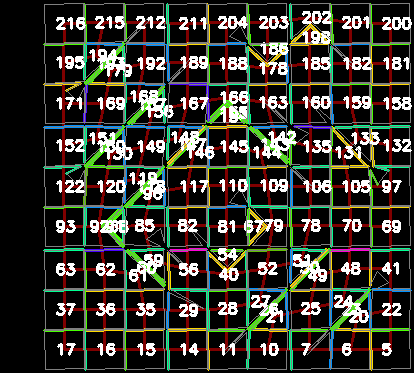

working on askew.png (420x364)


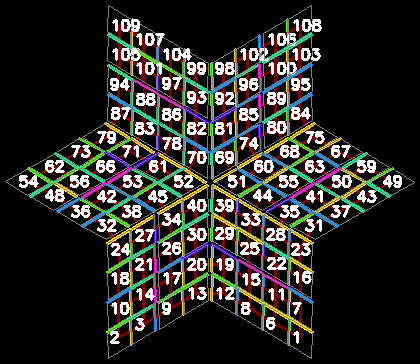

working on cages.png (723x723)


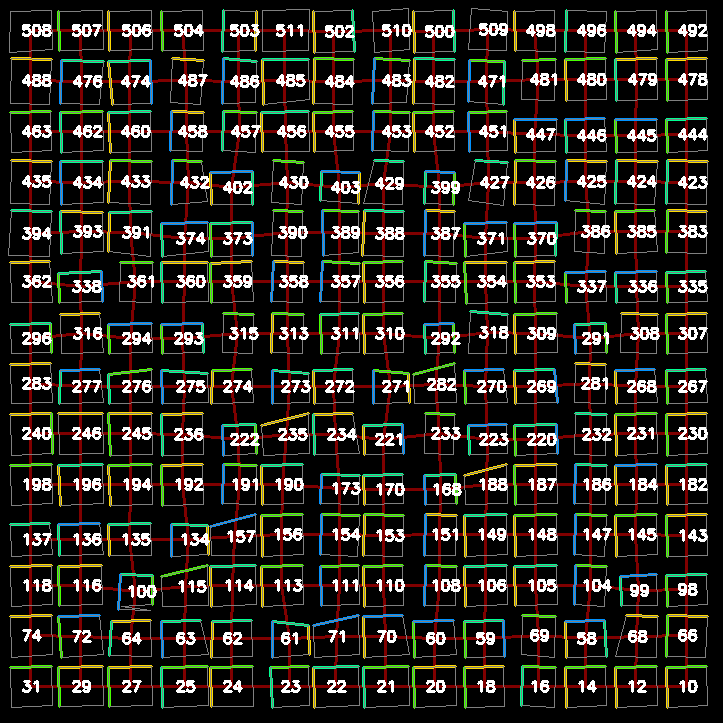

working on castlewall.png (437x403)


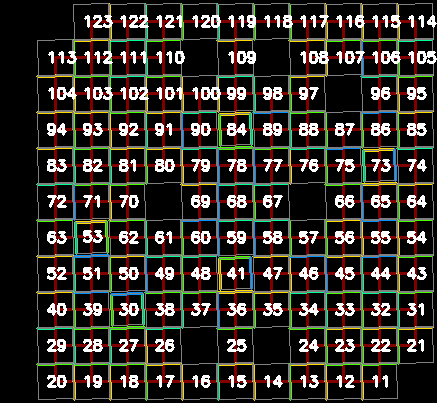

process
load:                 0 (0 calls)
contours:             93.13/s, 1.00x (4 calls, 42.95u)
findContours:         994.47/s, 10.68x (4 calls, 4.02u)
wall_segments:        1100.34/s, 11.82x (2263 calls, 2056.64u)
neighbors.fit:        2132.17/s, 22.90x (4 calls, 1.88u)
neighbors.kneighbors: 3741.26/s, 40.17x (514 calls, 137.39u)
grid:                 10066.16/s, 108.09x (4 calls, 0.40u)
drawing:              197701.61/s, 2122.94x (2263 calls, 11.45u)
dedupe:               404600.61/s, 4344.65x (4626 calls, 11.43u)


In [413]:
process = perf.Perf('process', [
  'contours', 'dedupe', 'drawing', 'findContours', 'grid', 'load', 'neighbors.fit', 'neighbors.kneighbors', 'wall_segments'])

#g = get_grid('spiral.png')
FOCUS = {
  #'askew.png': {
    #79, 56,
  #},
  #'castlewall.png': {
    #66, 73
  #},
}

for name, g in all_grids[0:4]:
  if FOCUS and name not in FOCUS:
    continue
  focus_points = FOCUS.get(name)
  with process['grid']:
    src = g.grid_without_threshold.copy()
    #show(src)

  height, width = src.shape
  area_threshold = (width * height) / 4  # Maximum allowed empty space.
  print('working on %s (%dx%d)' % (name, width, height))

  with process['findContours']:
    im2, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  hierarchy = hierarchy.reshape(hierarchy.shape[-2:])
  #print(hierarchy)
  #show_hierarchy(hierarchy)

  with process['contours']:
    filtered = process_contours(contours, hierarchy, 0, [], area_threshold)

  if not filtered:
    print('filter removed all contours')
    continue

  n_neighbors = 9  # Assumes 3x3 grid of 2d squares.
  with process.benchmark('neighbors.fit'):
    neighbors = NearestNeighbors(n_neighbors)  
    neighbors.fit([(c.cX, c.cY) for c in filtered])

  # 840 / 701.71u -> 479 / 388.37u.
  visited = set()
  image = np.zeros((height, width, 3), np.uint8)
  for target in filtered:
    focused = not focus_points or int(target.name) in focus_points
    with process.benchmark('neighbors.kneighbors'):
      d, n = neighbors.kneighbors([(target.cX, target.cY)], n_neighbors=n_neighbors)
    colors = coloring.colors(n_neighbors)
    for dist, pos, color in zip(*d, *n, colors):
      color = color.tolist()
      c = filtered[pos]
      if focus_points and int(c.name) not in focus_points:
        continue
      with process['dedupe']:
        if c.name < target.name:
          key = '%s:%s' % (c.name, target.name)
        else:
          key = '%s:%s' % (target.name, c.name)
        dupe = key in visited
      if dupe:
        continue
      visited.add(key)
      if dist:
        with process.benchmark('wall_segments'):
          segments = wall_segments(target, c)
        if segments:
          cv2.line(image, (target.cX, target.cY), (c.cX, c.cY), (128, 0, 0), 2)
        #  print('%s -> %s: %s' % (c.name, target.name, len(segments)))
        with process['drawing']:
          for s1, s2, _ in segments:
            cv2.line(image, tuple(s1[0]), tuple(s1[1]), color, 2)
            #cv2.line(image, tuple(s2[0]), tuple(s2[1]), color, 2)
    target.draw_on(image, color=(128, 128, 128), bold=focused)
  show(image)

print(process)


arrow.png 368


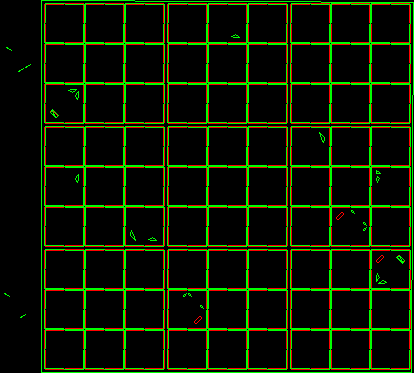

askew.png 98


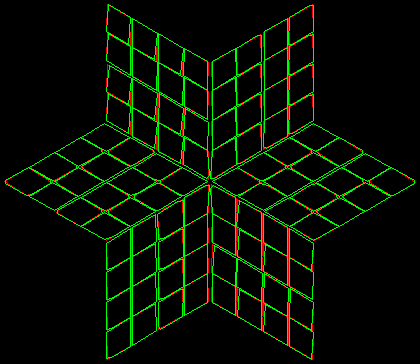

cages.png 188


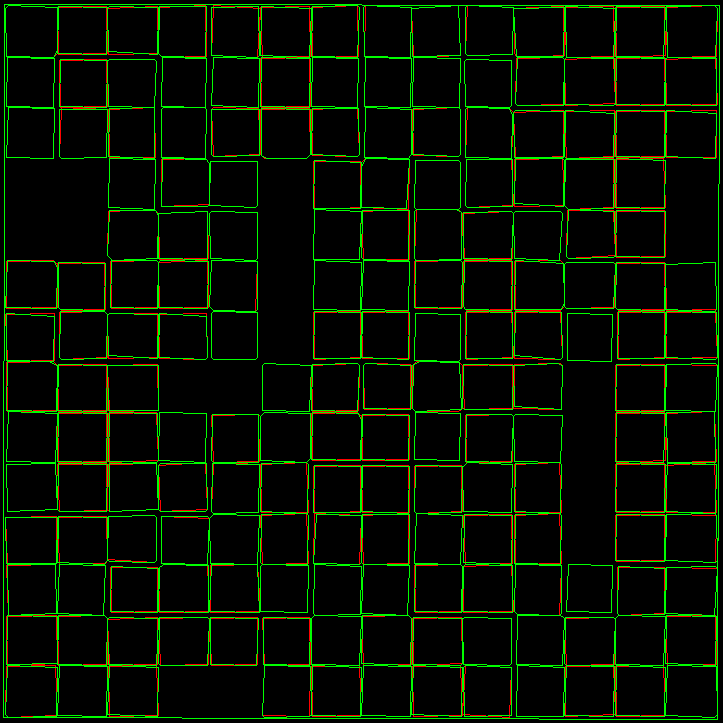

castlewall.png 131


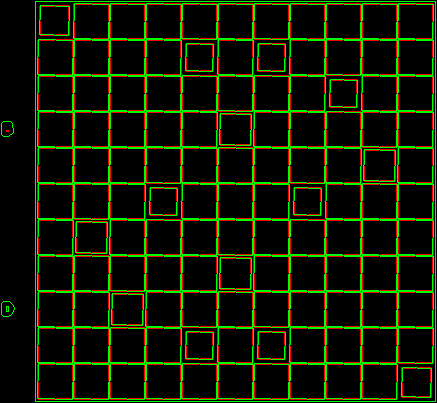

crossword.png 190


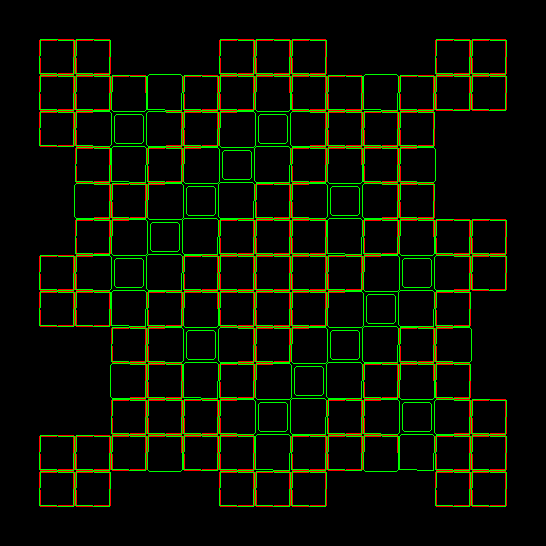

fillomino.png 542


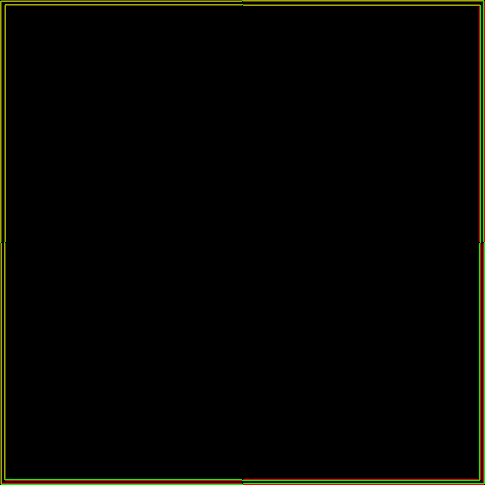

kakuro.png 75


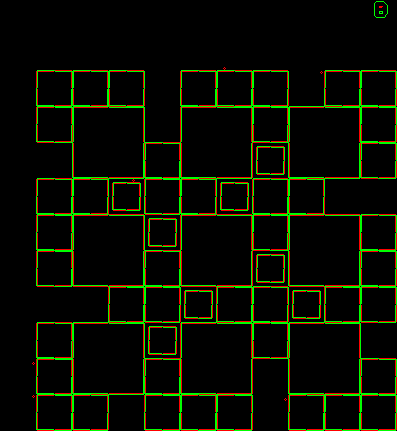

kenken.png 41


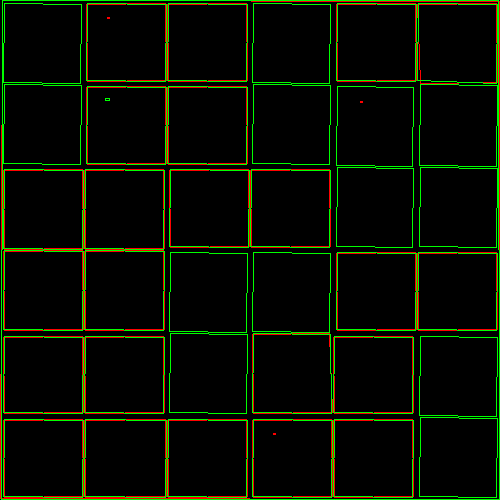

masyu.png 1458


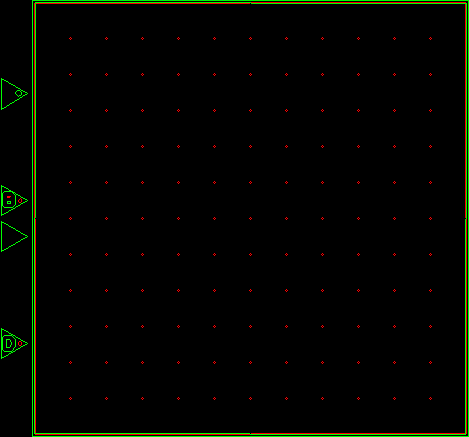

multi.png 193


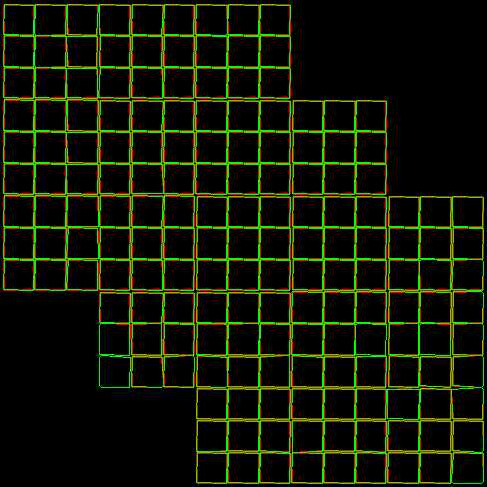

nonogram.png 542


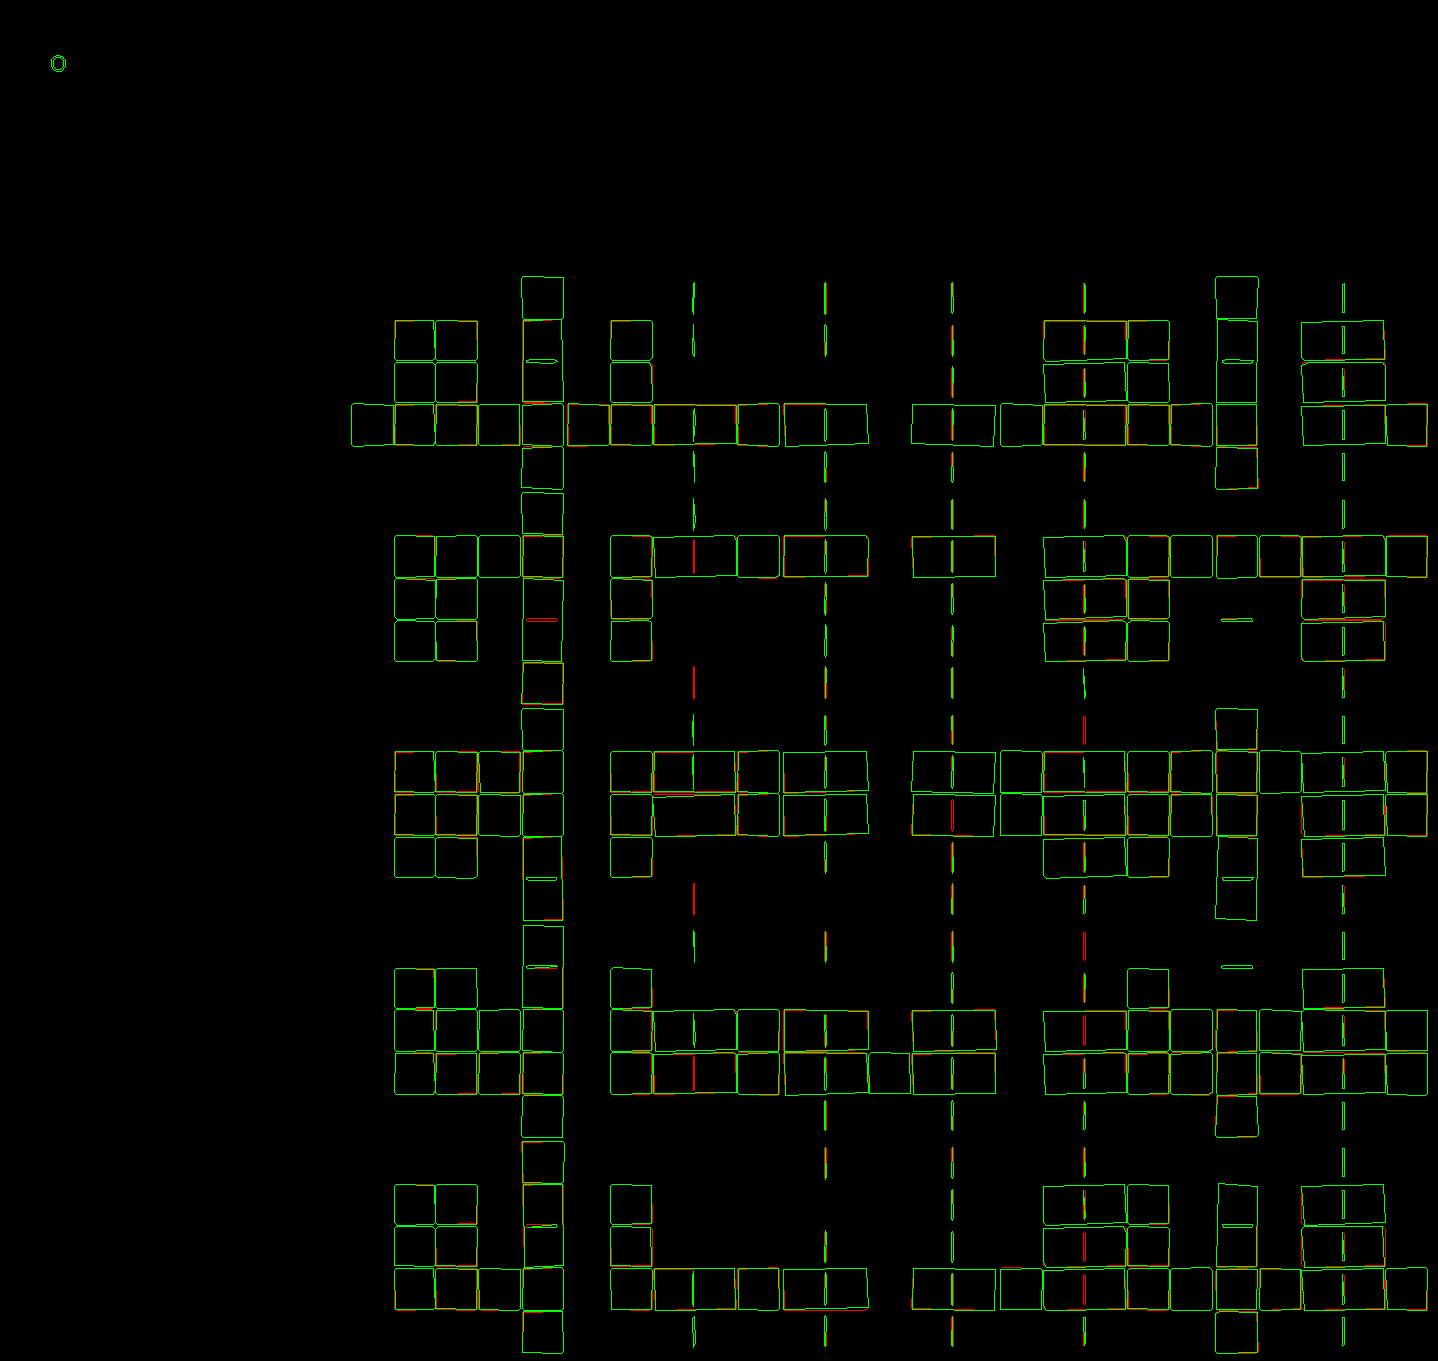

nurimaze.png 919


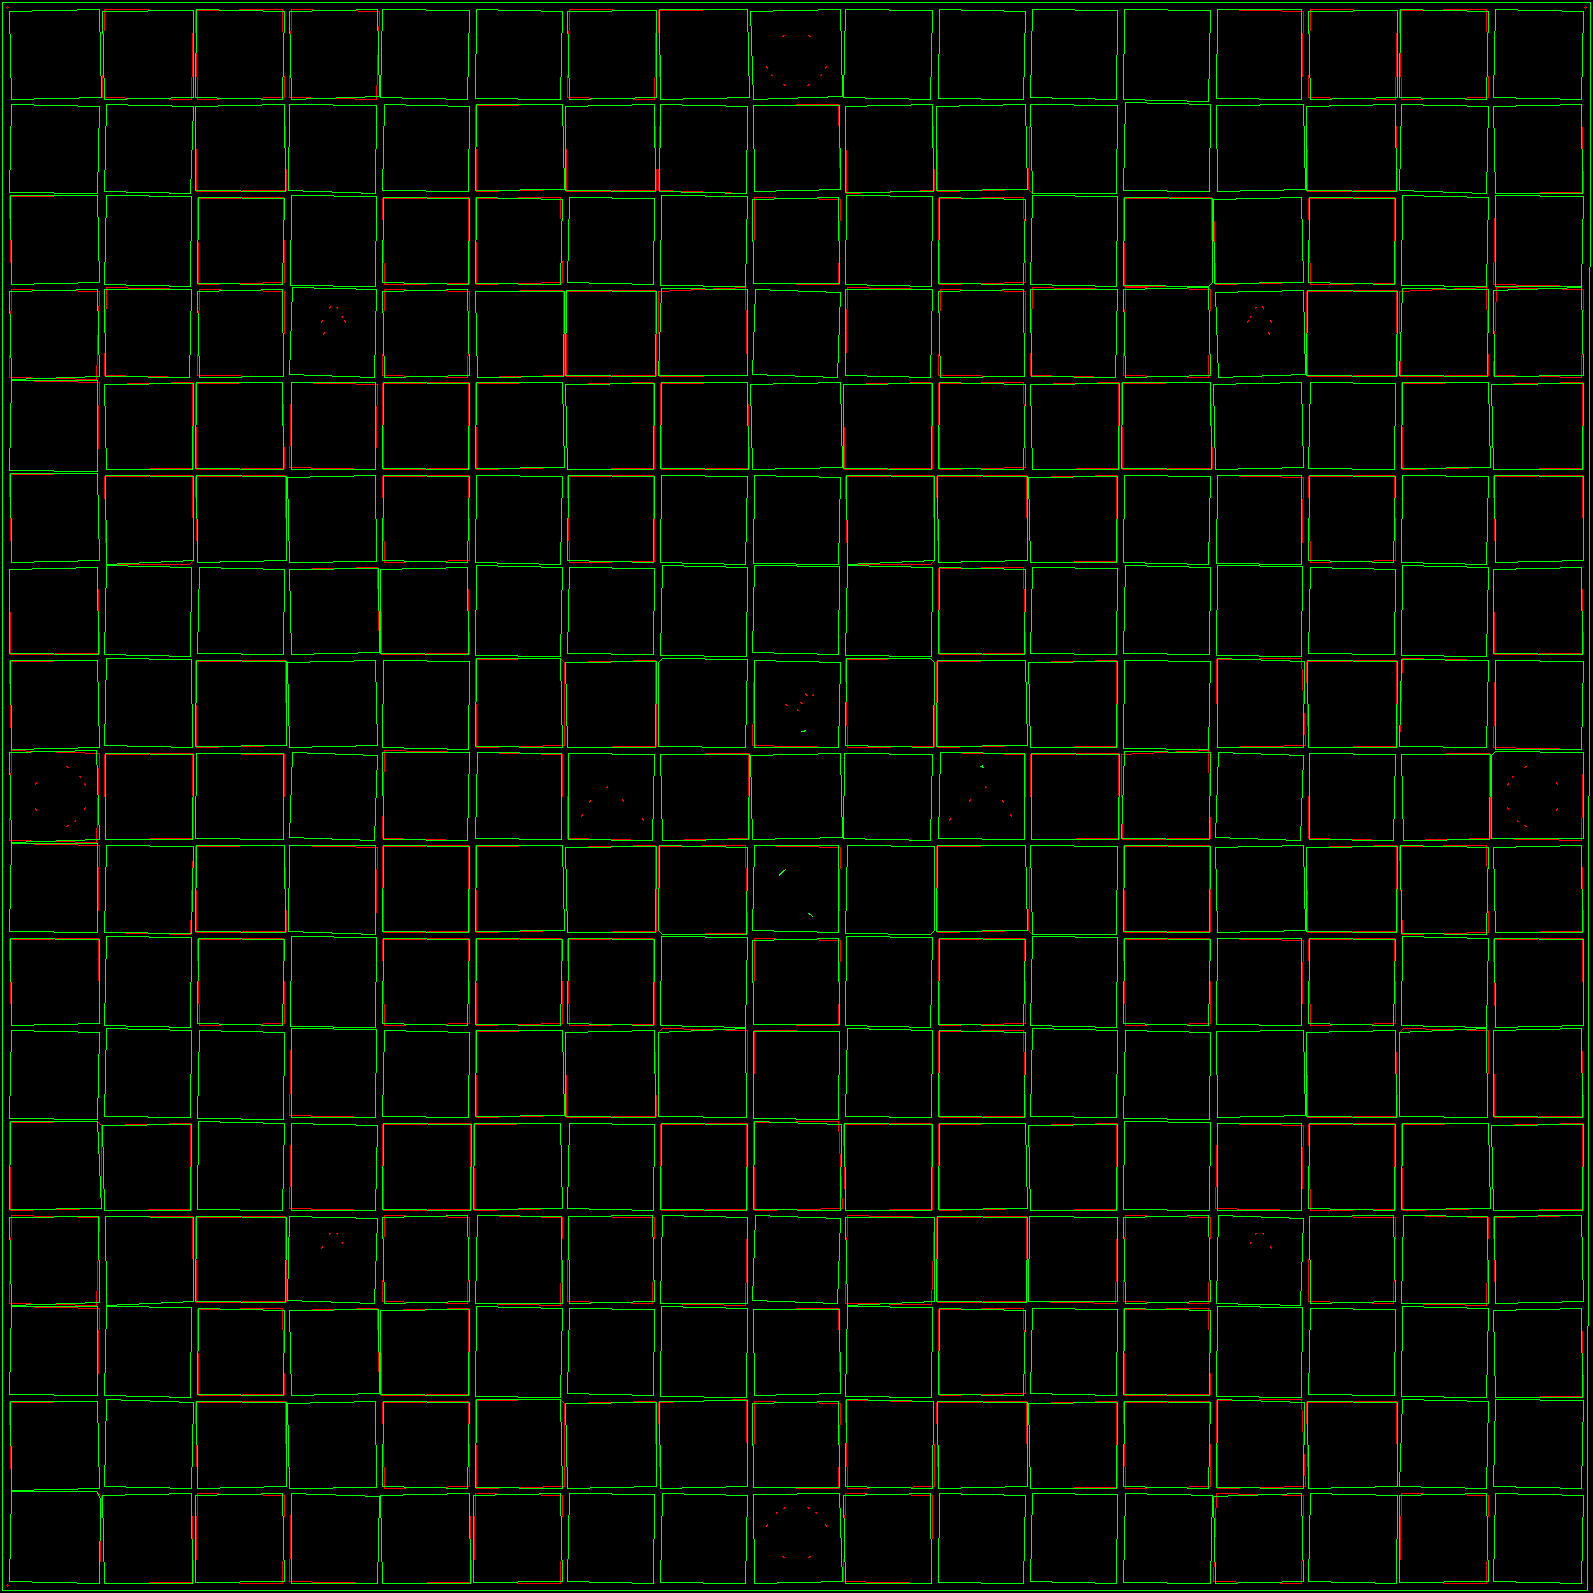

pentopia.png 340


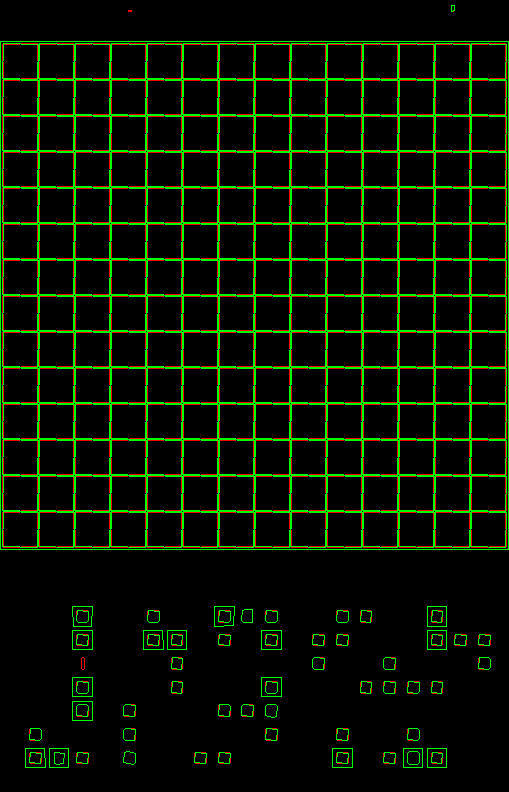

skyscraper.png 40


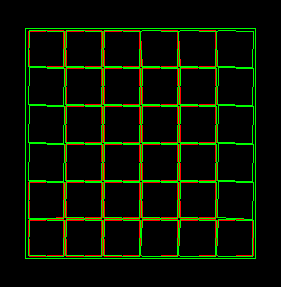

slitherlink.png 144


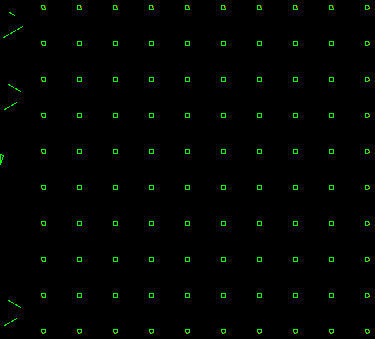

spiral.png 146


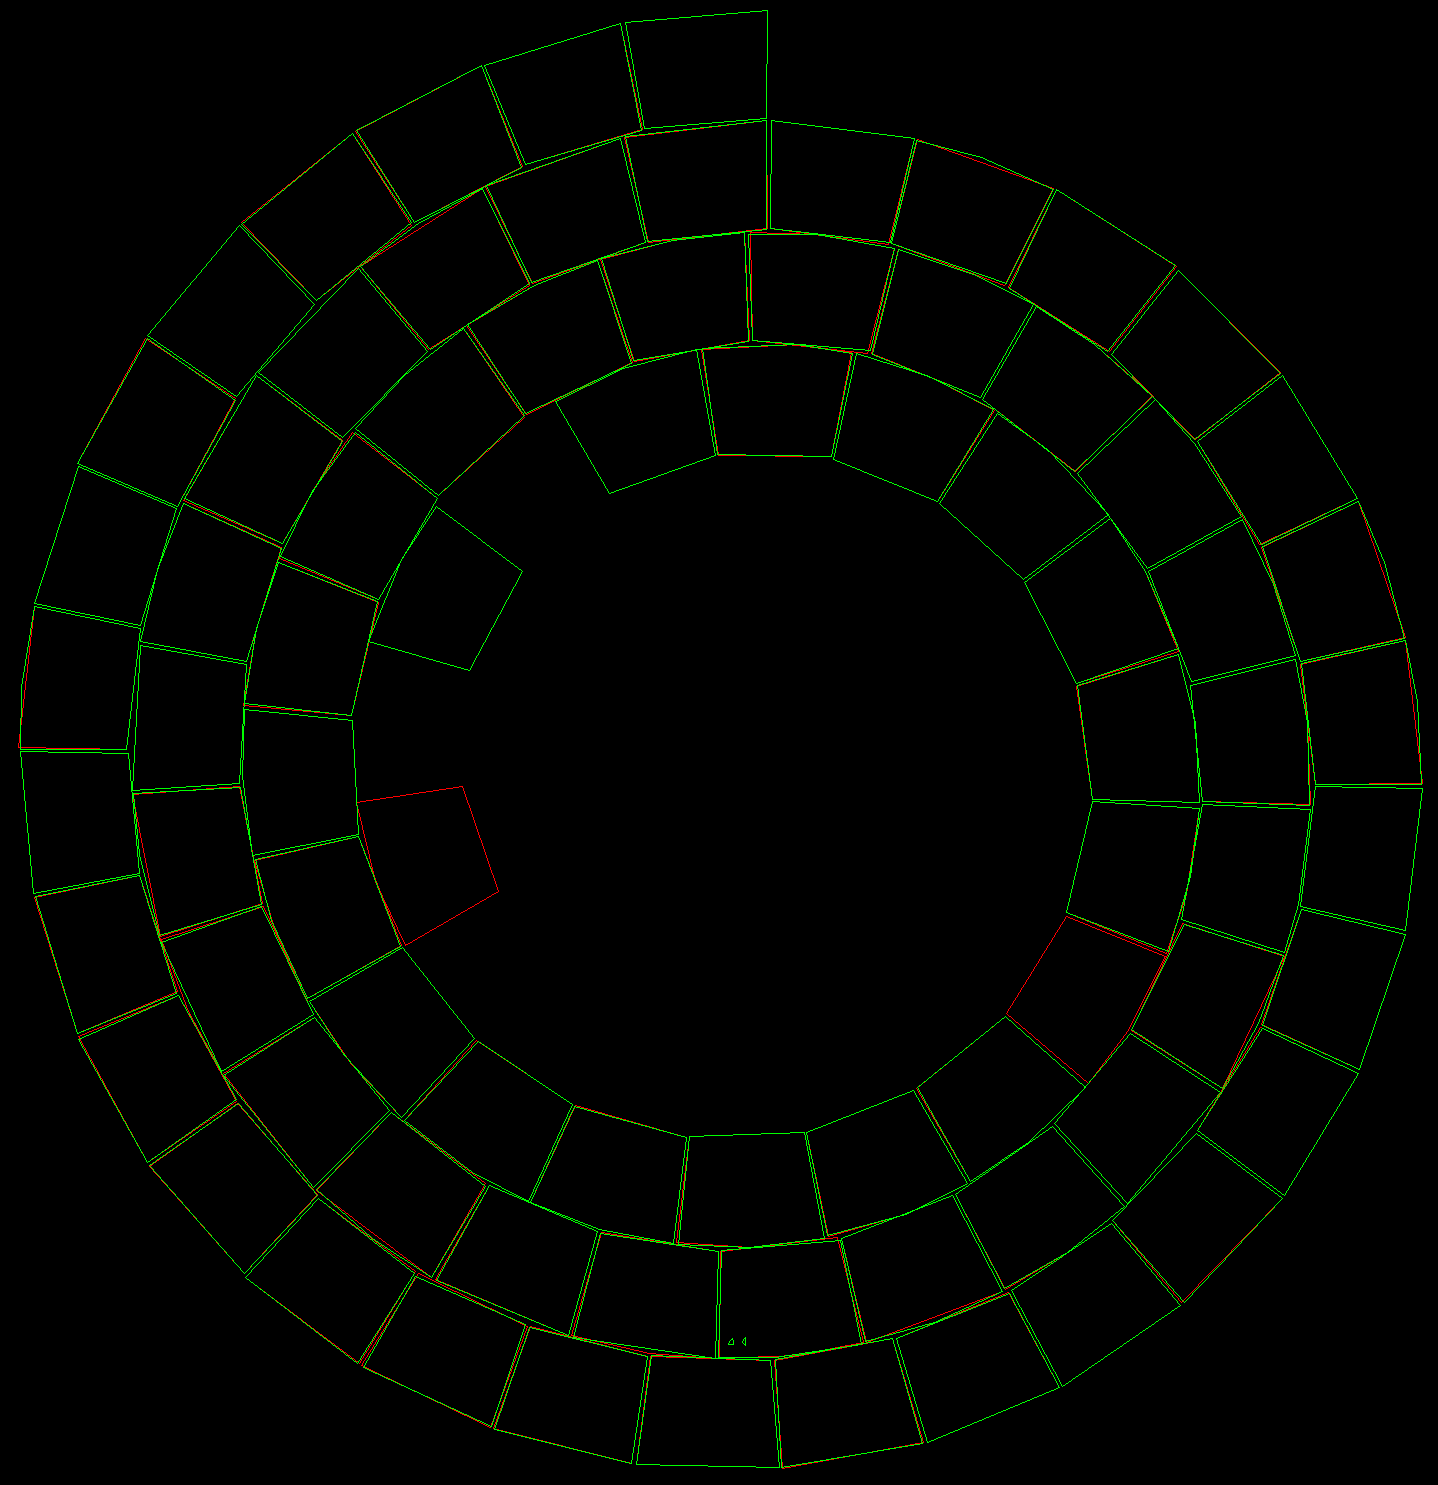

strimko.png 24


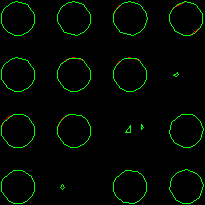

thermo.png 171


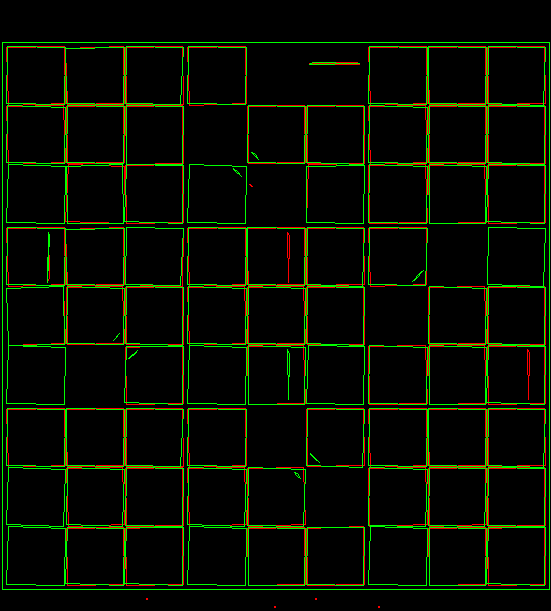

wordsearch.png 252


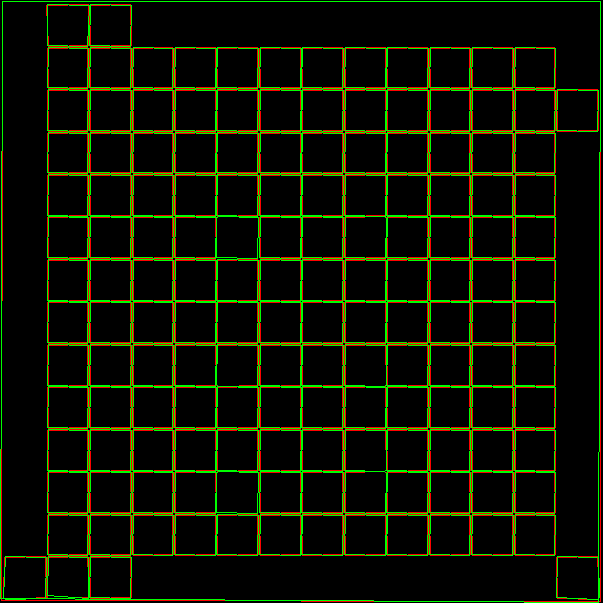

wordsearch_with_bank.png 103


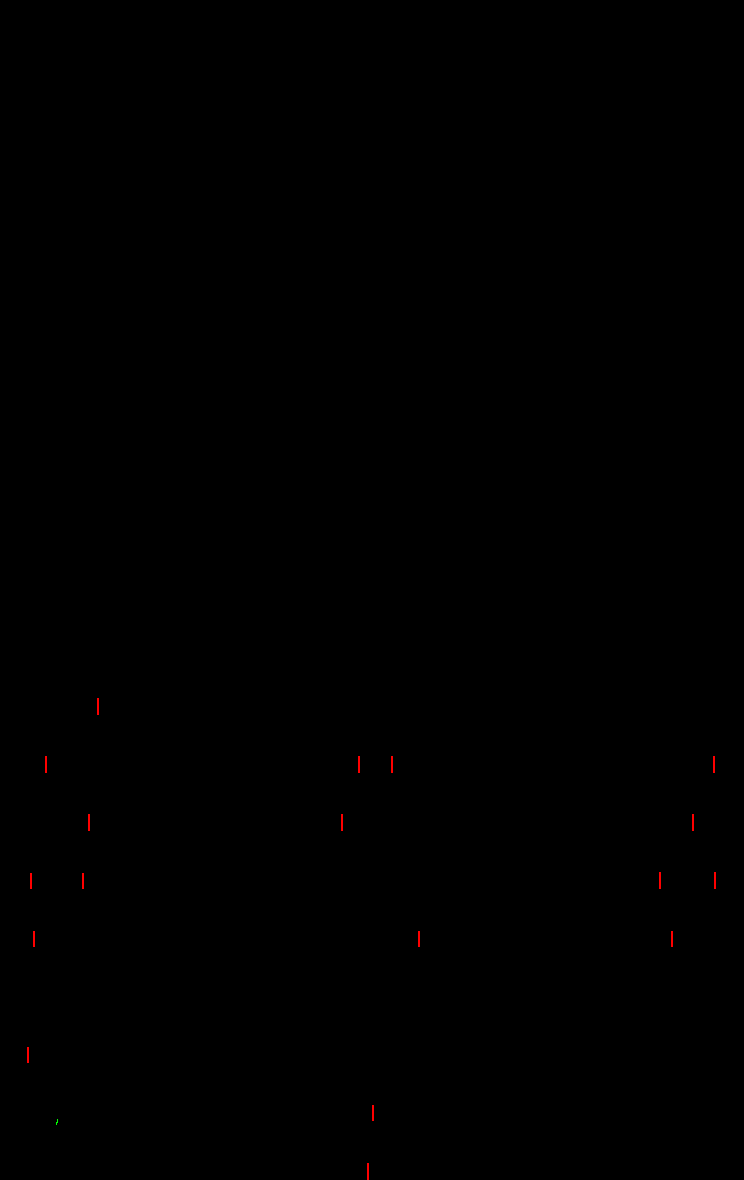

In [31]:
for name, g in grids():
  height, width = g.grid.shape
  image = np.zeros((height, width, 3), np.uint8)
  im2, contours, hierarchy = cv2.findContours(g.grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (255, 0, 0), 1)
  im2, contours, hierarchy = cv2.findContours(g.grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (0, 255, 0), 1)
  print(name, len(contours))
  show(image)

arrow.png
[255, 255]


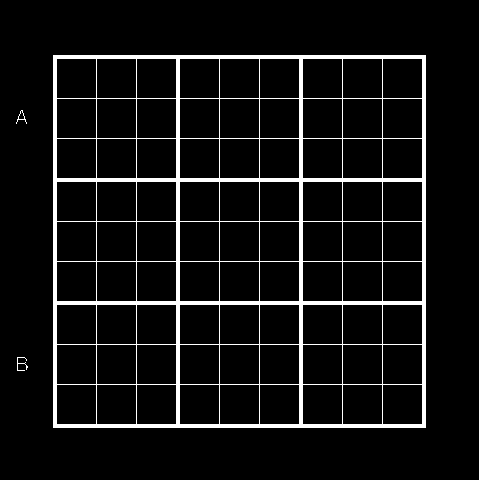

preserved


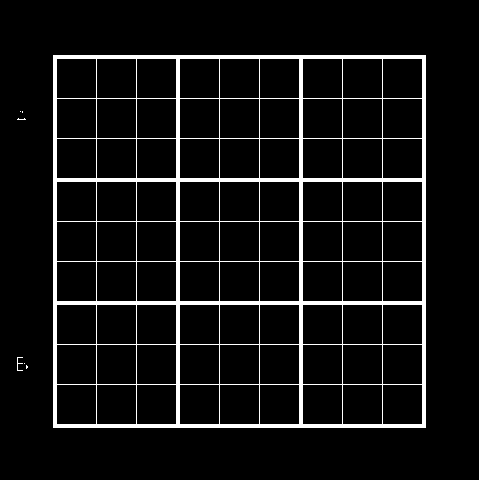

[59, 63]


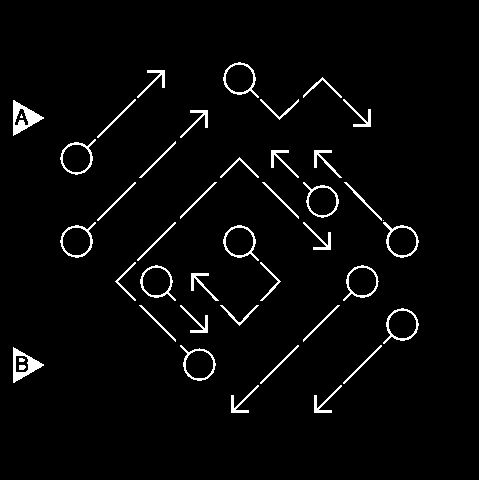

preserved


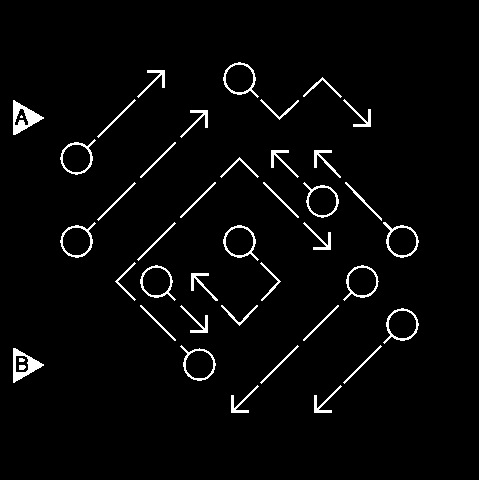

[0, 0]


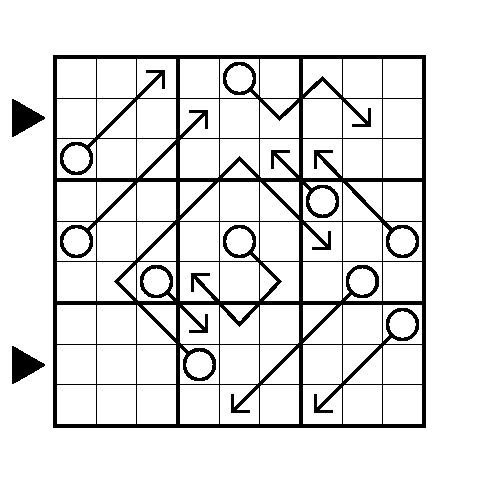

preserved


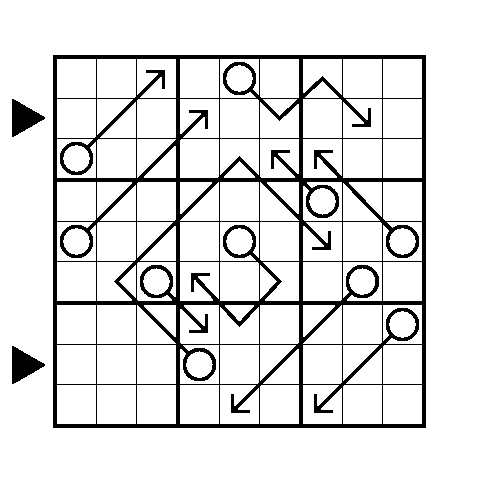

castlewall.png
[255, 255]


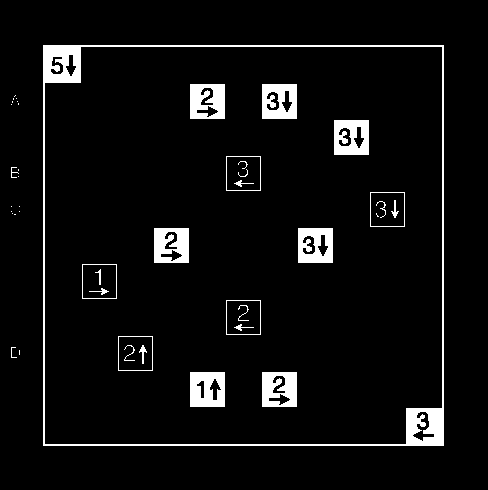

preserved


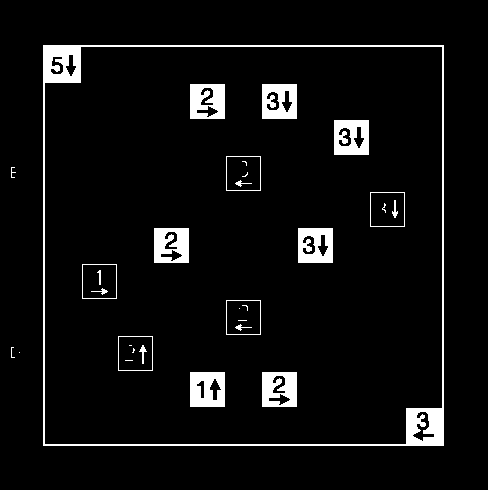

[57, 57]


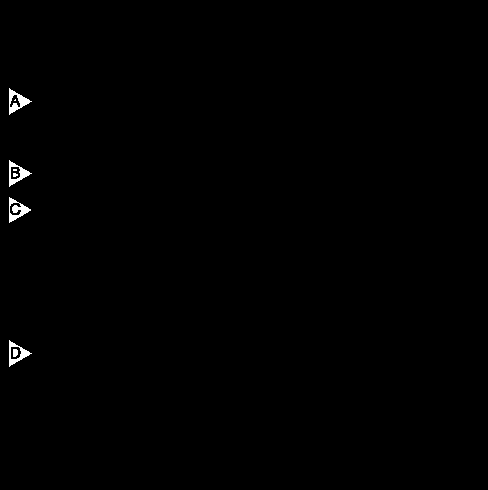

preserved


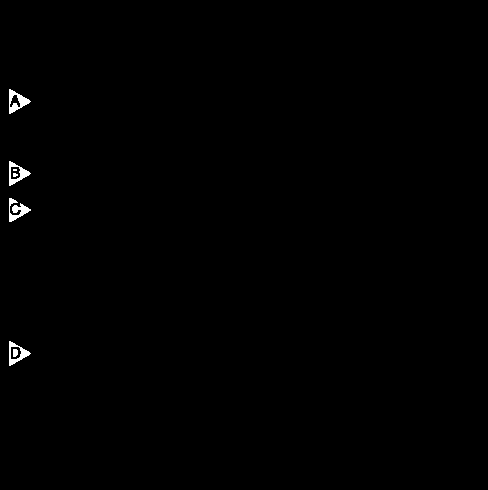

[0, 0]


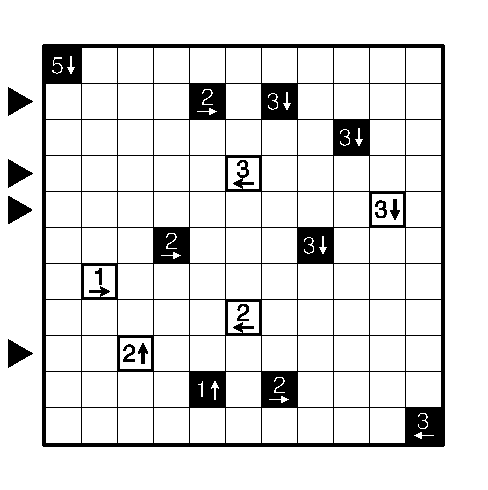

preserved


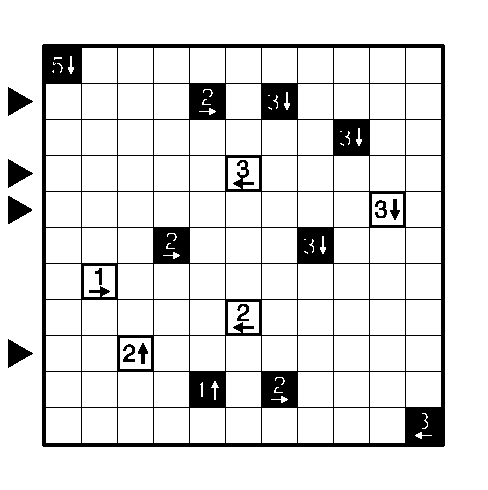

kenken.png
[255, 255]


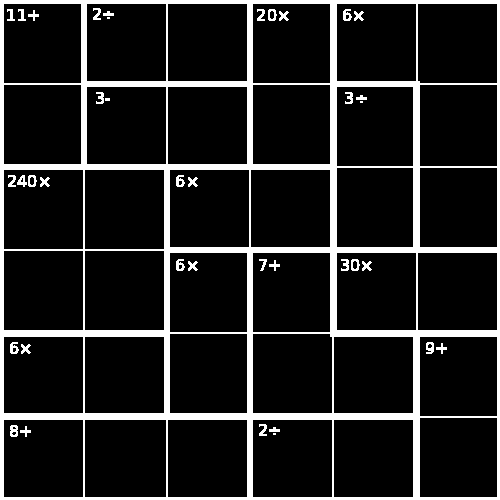

preserved


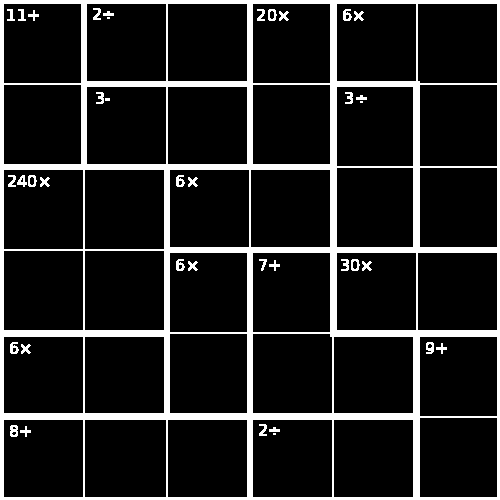

[0, 0]


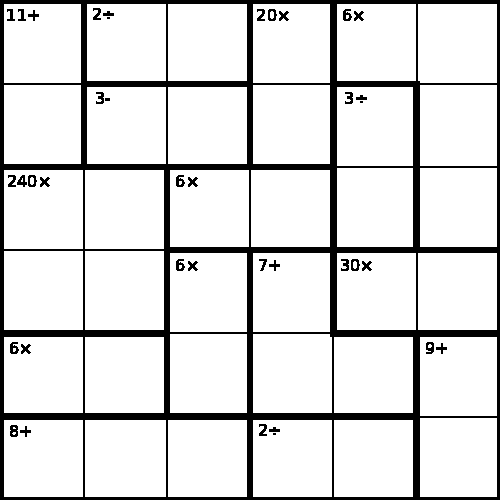

preserved


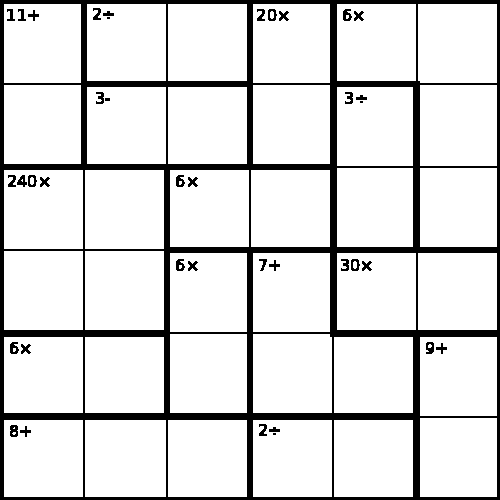

nonogram.png
[255, 255]


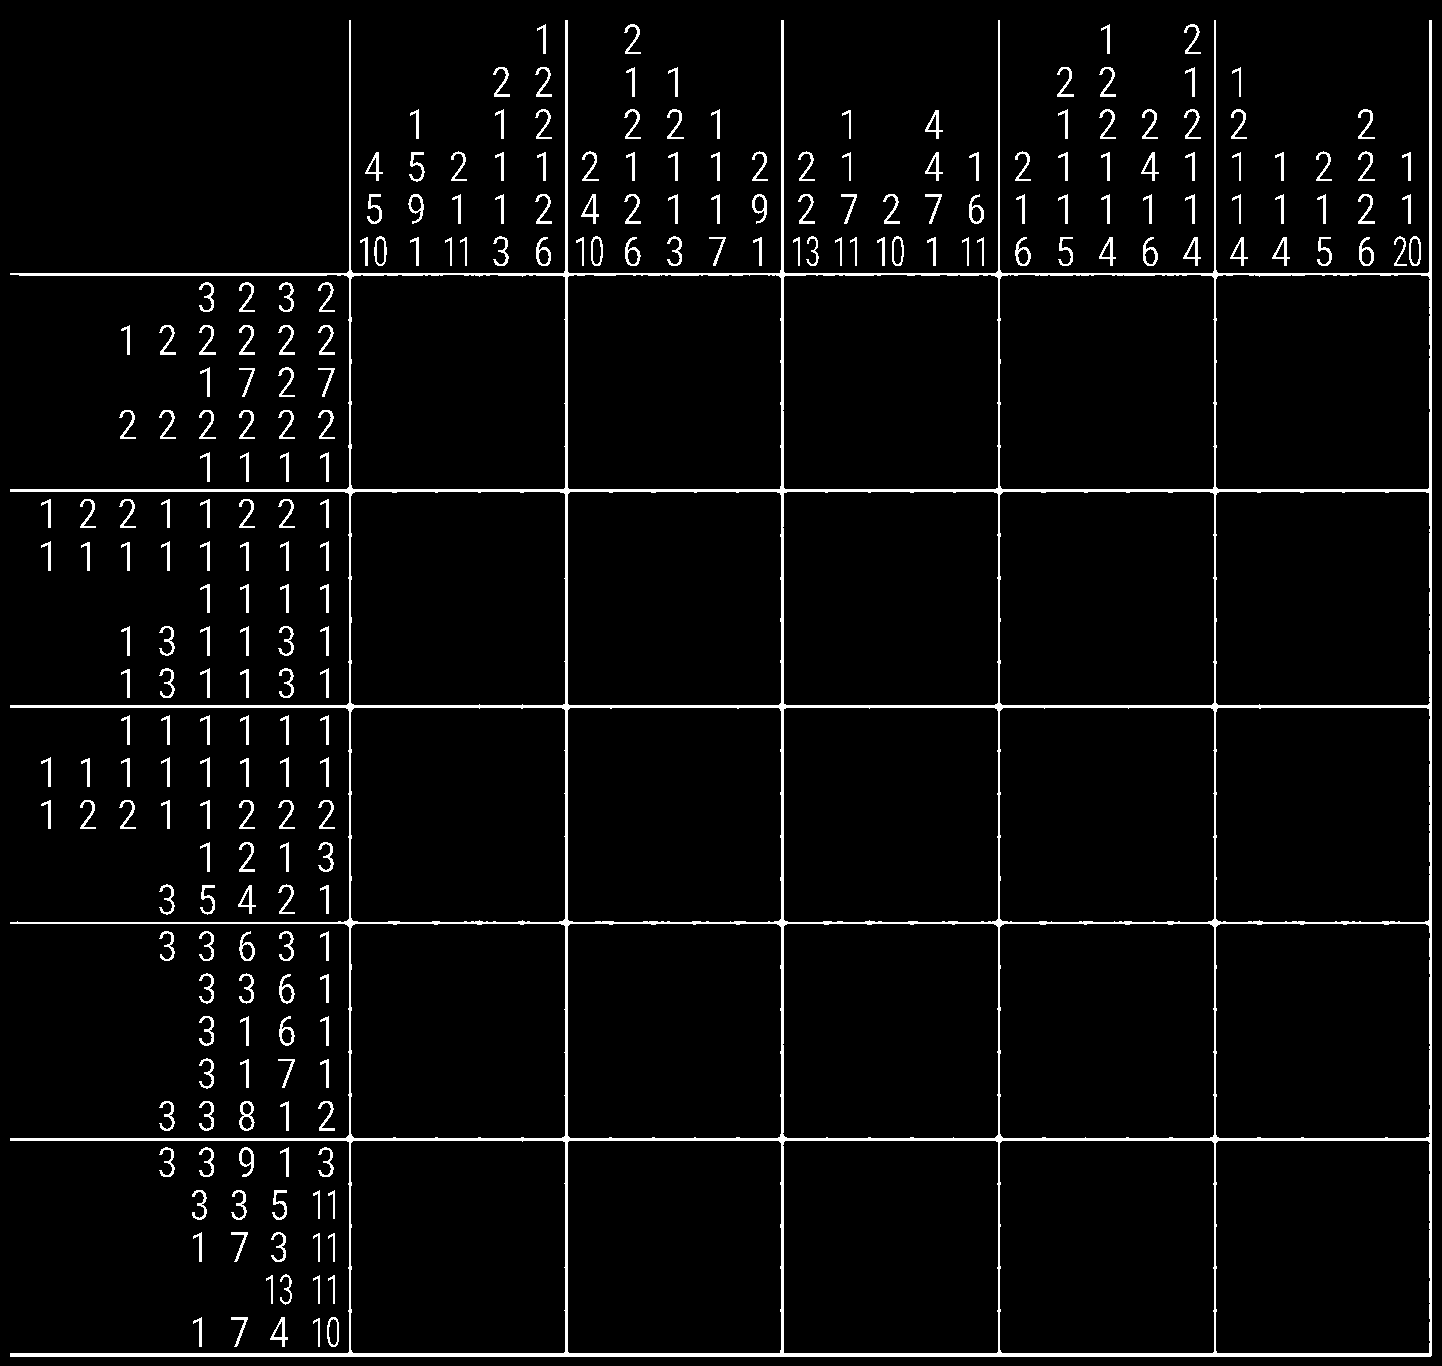

preserved


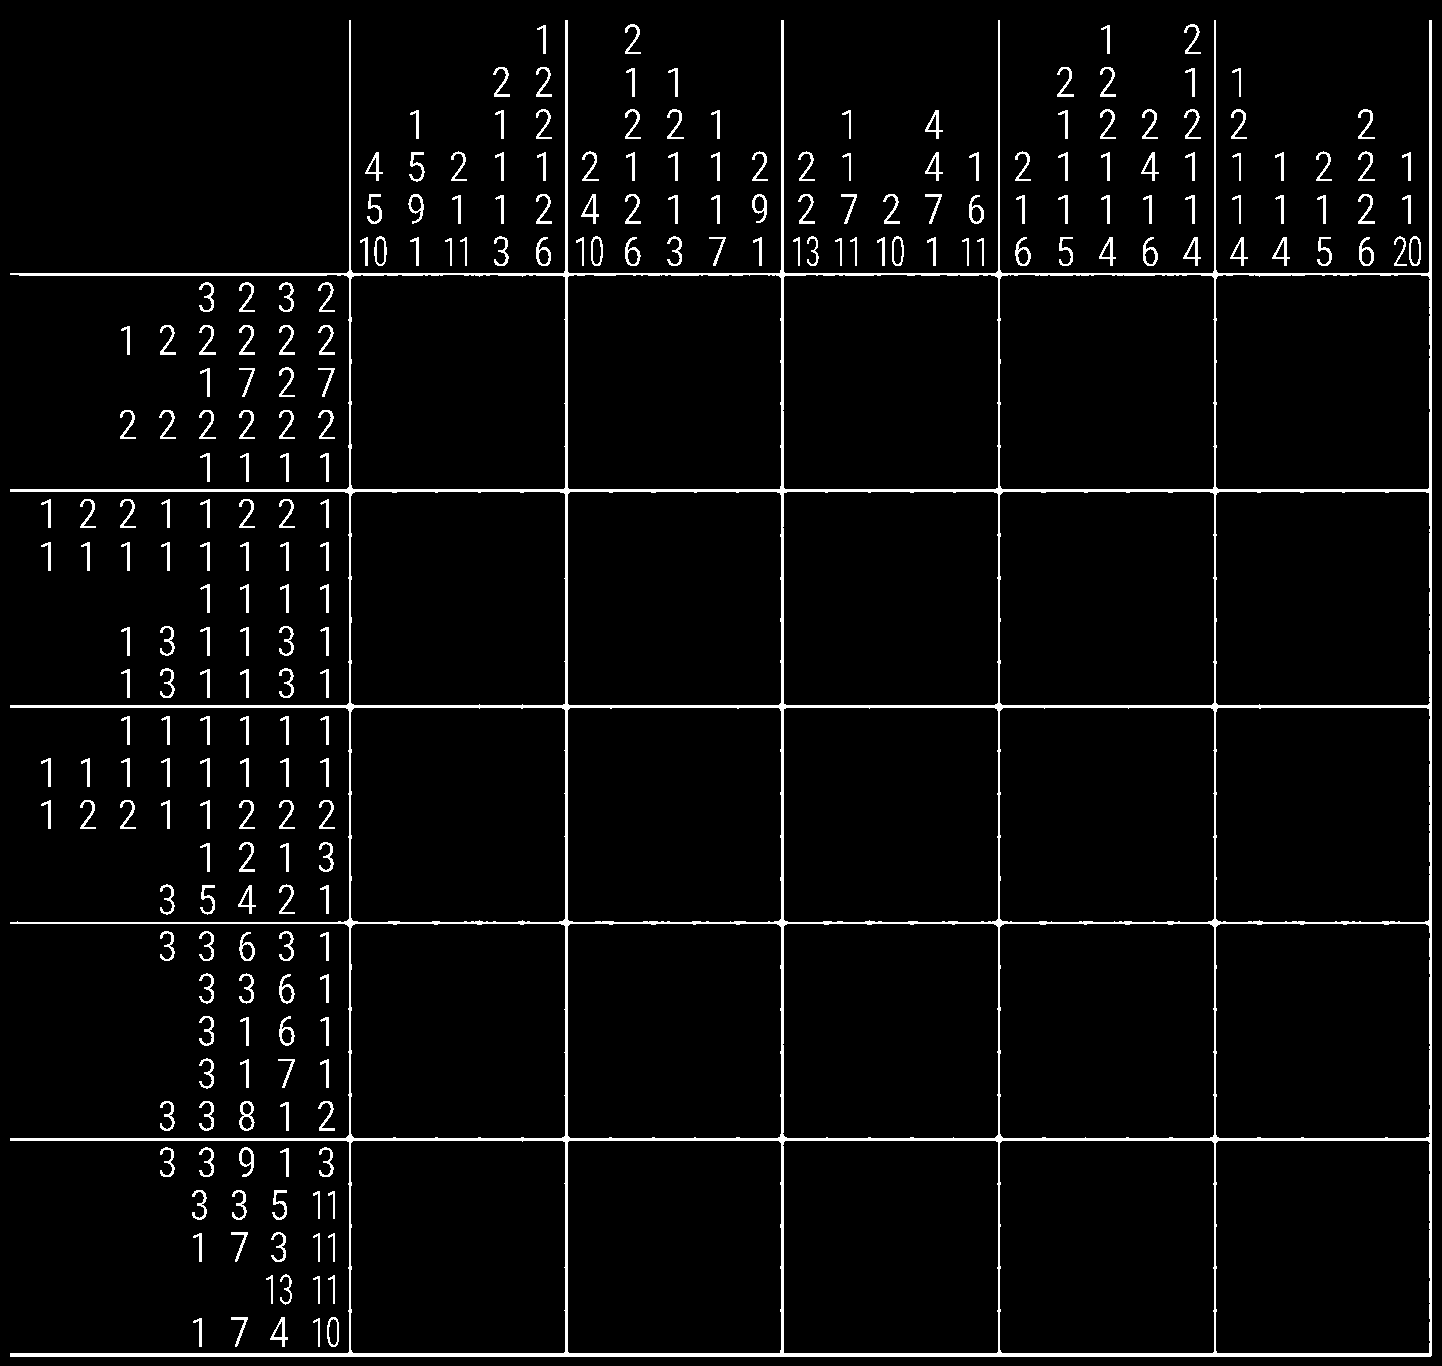

[0, 4]


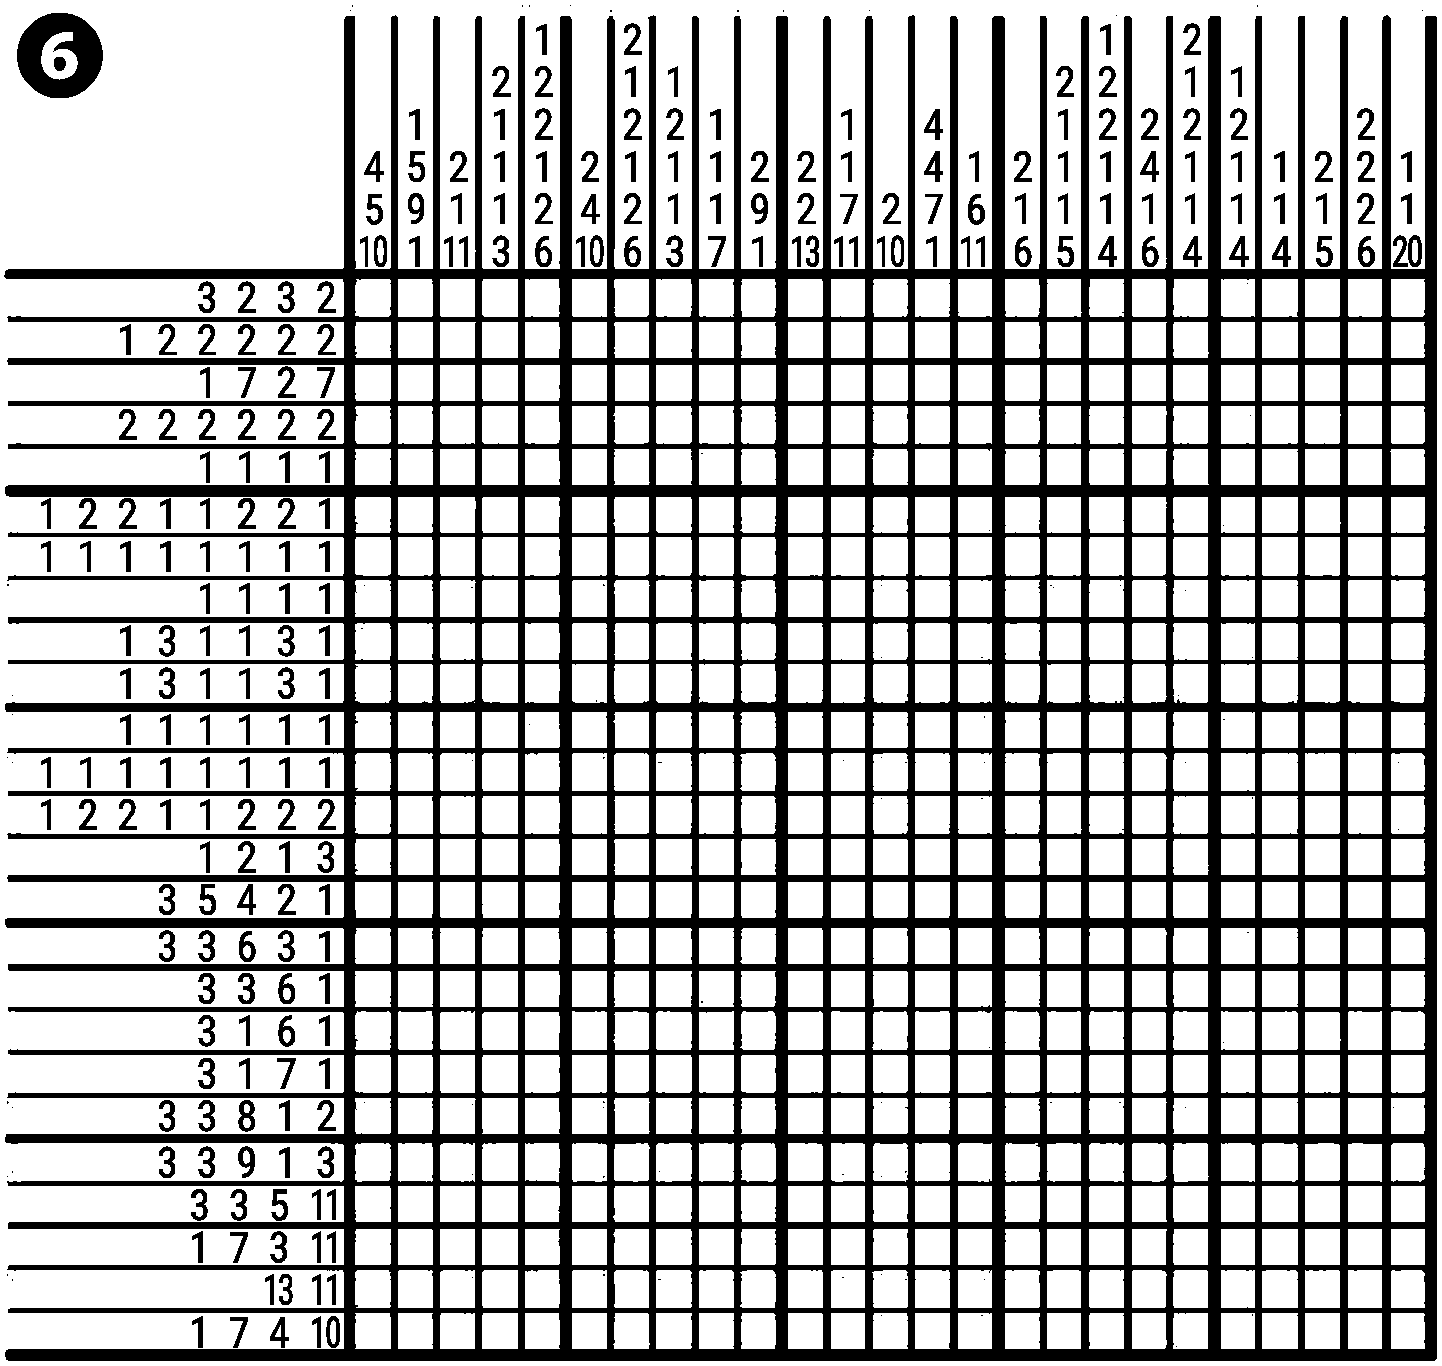

preserved


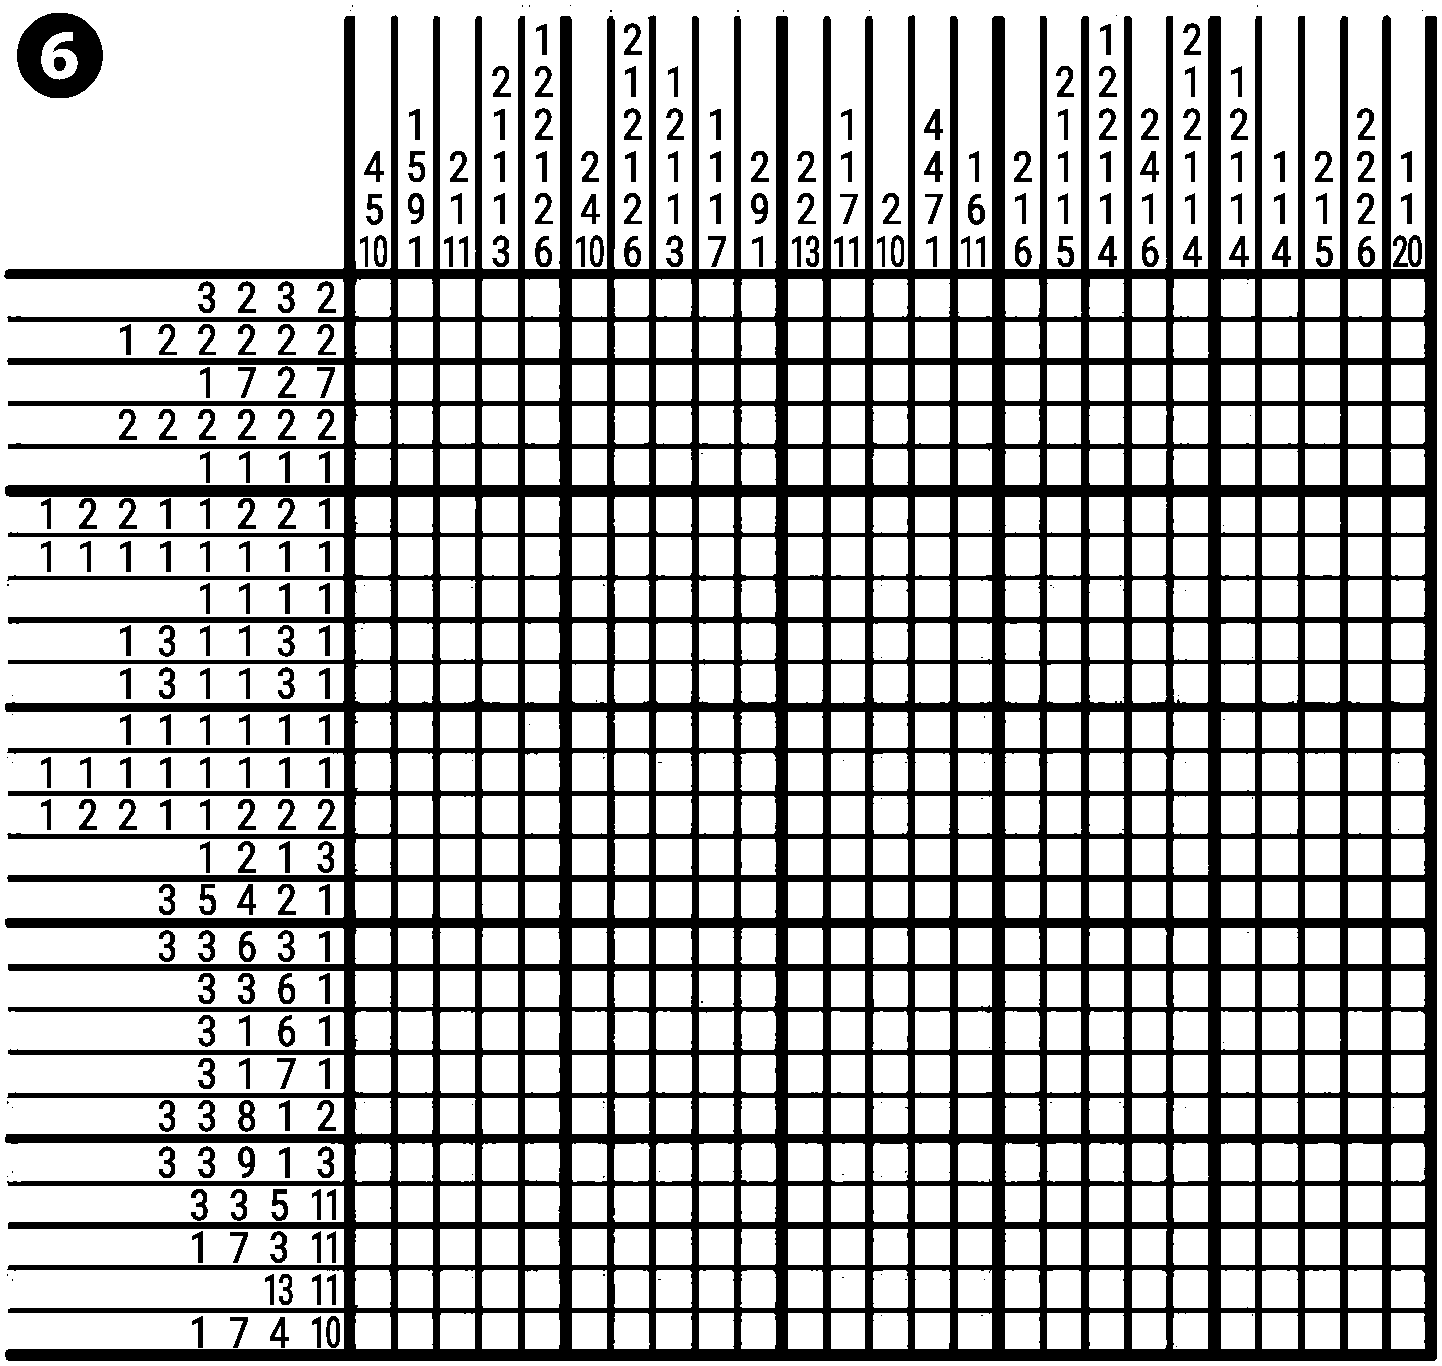

strimko.png
[255, 255]


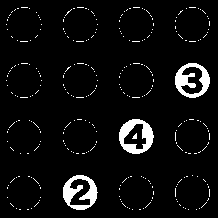

preserved


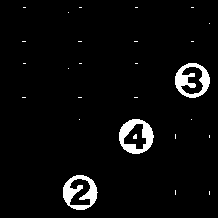

[0, 6]


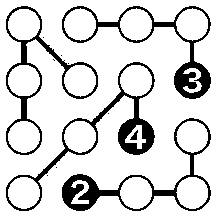

preserved


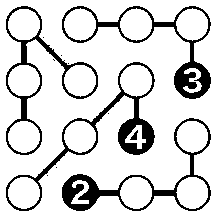

thermo.png
[255, 255]


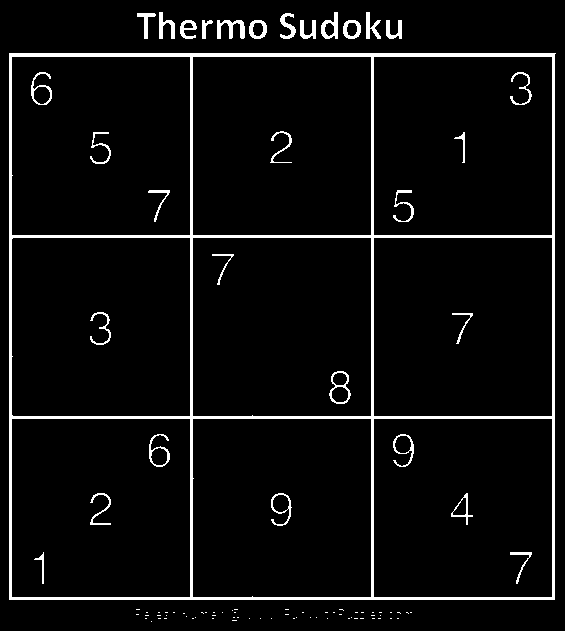

preserved


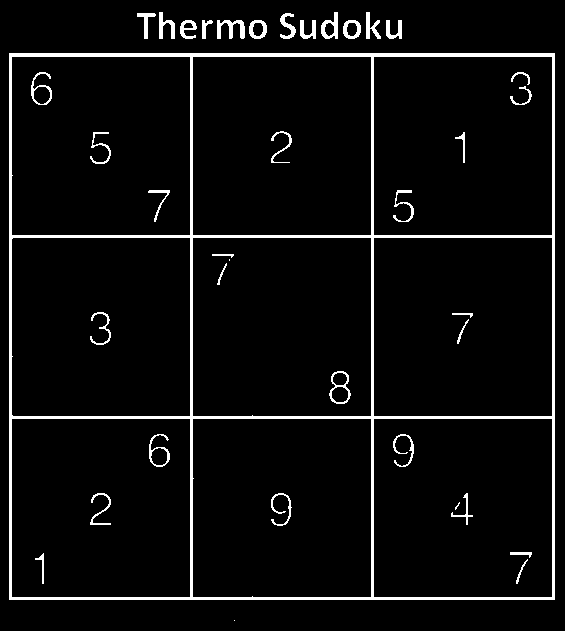

[72, 76]


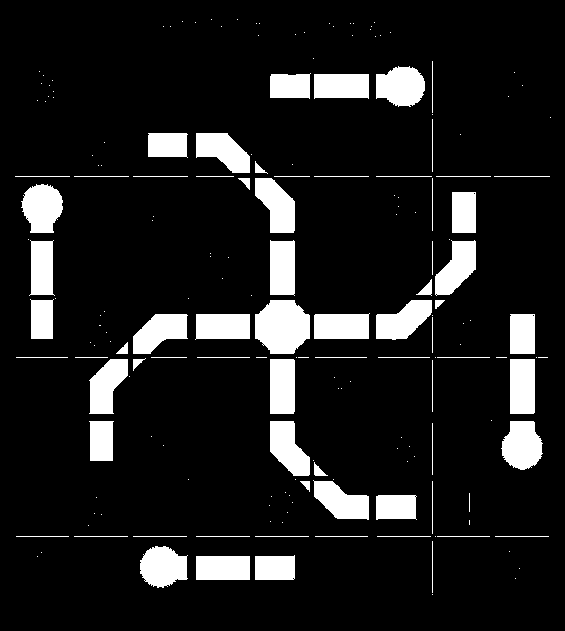

preserved


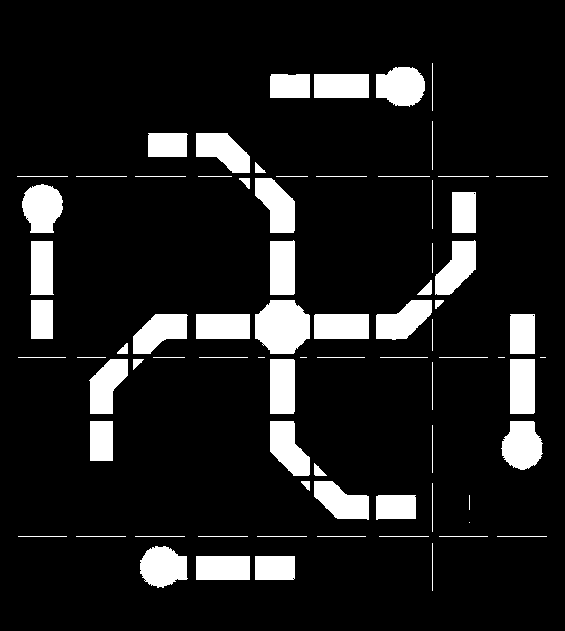

[0, 0]


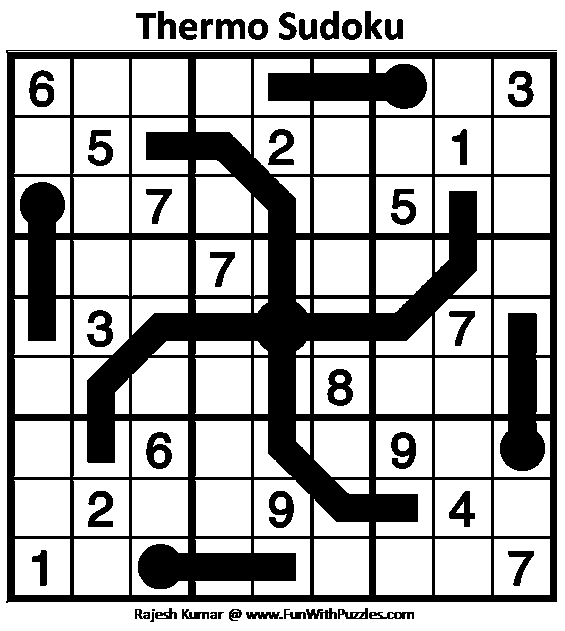

preserved


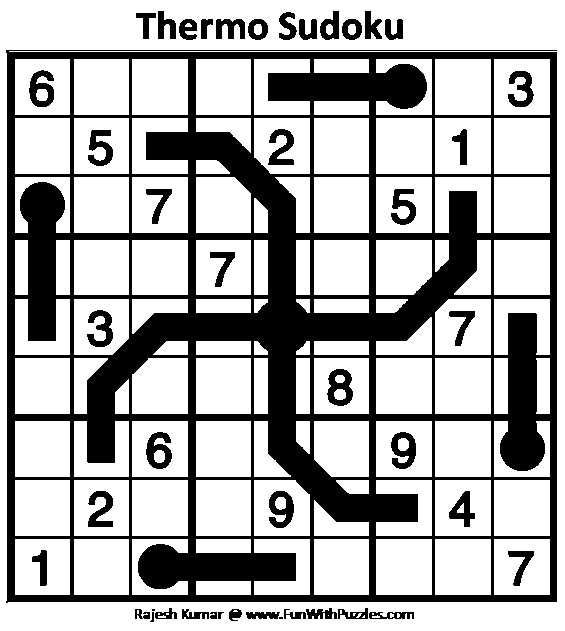

In [106]:
from data.image import analysis, coloring, component, component_database, grid, image, utils

importlib.reload(coloring)
importlib.reload(analysis)
importlib.reload(grid)
importlib.reload(image)
importlib.reload(np2d)
importlib.reload(utils)

_FOCUS = {
  'arrow.png',
  'castlewall.png',
  'kenken.png',
  'nonogram.png',
  'thermo.png',
  'strimko.png',
}

for n, i in images():
  i.normalize().invert().grayscale().enhance()
  print(n)
  bands = analysis.significant_color_bands(i)
  for (low, high), band in bands:
    show('[%s, %s]' % (low, high), band)


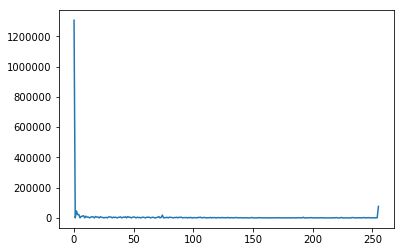

[[74]]


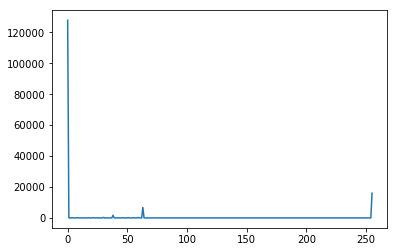

[[30], [38], [59, 63]]


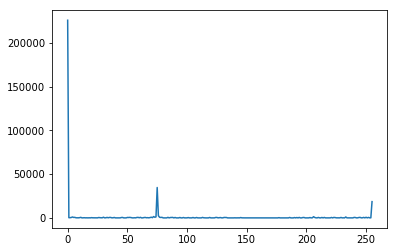

[[72, 75, 76], [206]]


In [10]:
importlib.reload(grid)
importlib.reload(np2d)
importlib.reload(utils)
importlib.reload(coloring)

g = get_grid('nonogram.png')
plt.plot(g._grayscale_inv_bincount)
plt.show()
print(list(coloring.top_n_color_clusters(g._grayscale_inv_bincount, 6)))
#print(len(g._grayscale_inv_bincount))

#list(g._layer_masks(10, show))

g = get_grid('arrow.png')
plt.plot(g._grayscale_inv_bincount)
plt.show()
print(list(coloring.top_n_color_clusters(g._grayscale_inv_bincount, 6)))


g = get_grid('thermo.png')
plt.plot(g._grayscale_inv_bincount)
plt.show()
print(list(coloring.top_n_color_clusters(g._grayscale_inv_bincount, 6)))
